## 1. import 불러오기

In [3]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

## 2. Data 출력

데이터 리스트 출력

In [4]:
file_list = os.listdir("./data")
file_list

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']

### 2.1 Meta csv파일 확인

dataframe으로 불러오기

In [5]:
import pandas as pd
df_meta =  pd.read_csv('./data/Meta.csv')
df_meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


Meta png 요소
classid - 각 표지판 고유번호 
shapedId - 0 : 삼각형
           1 : 동그라미
           2 : 다이아몬드
           3 : 육각형
           4 : 역삼각형
colorid - 빨 (0)
          파 (1)
          노 (2)
          흰 (3)

 교통표지판 데이터   
 Meta_image, Meta_label

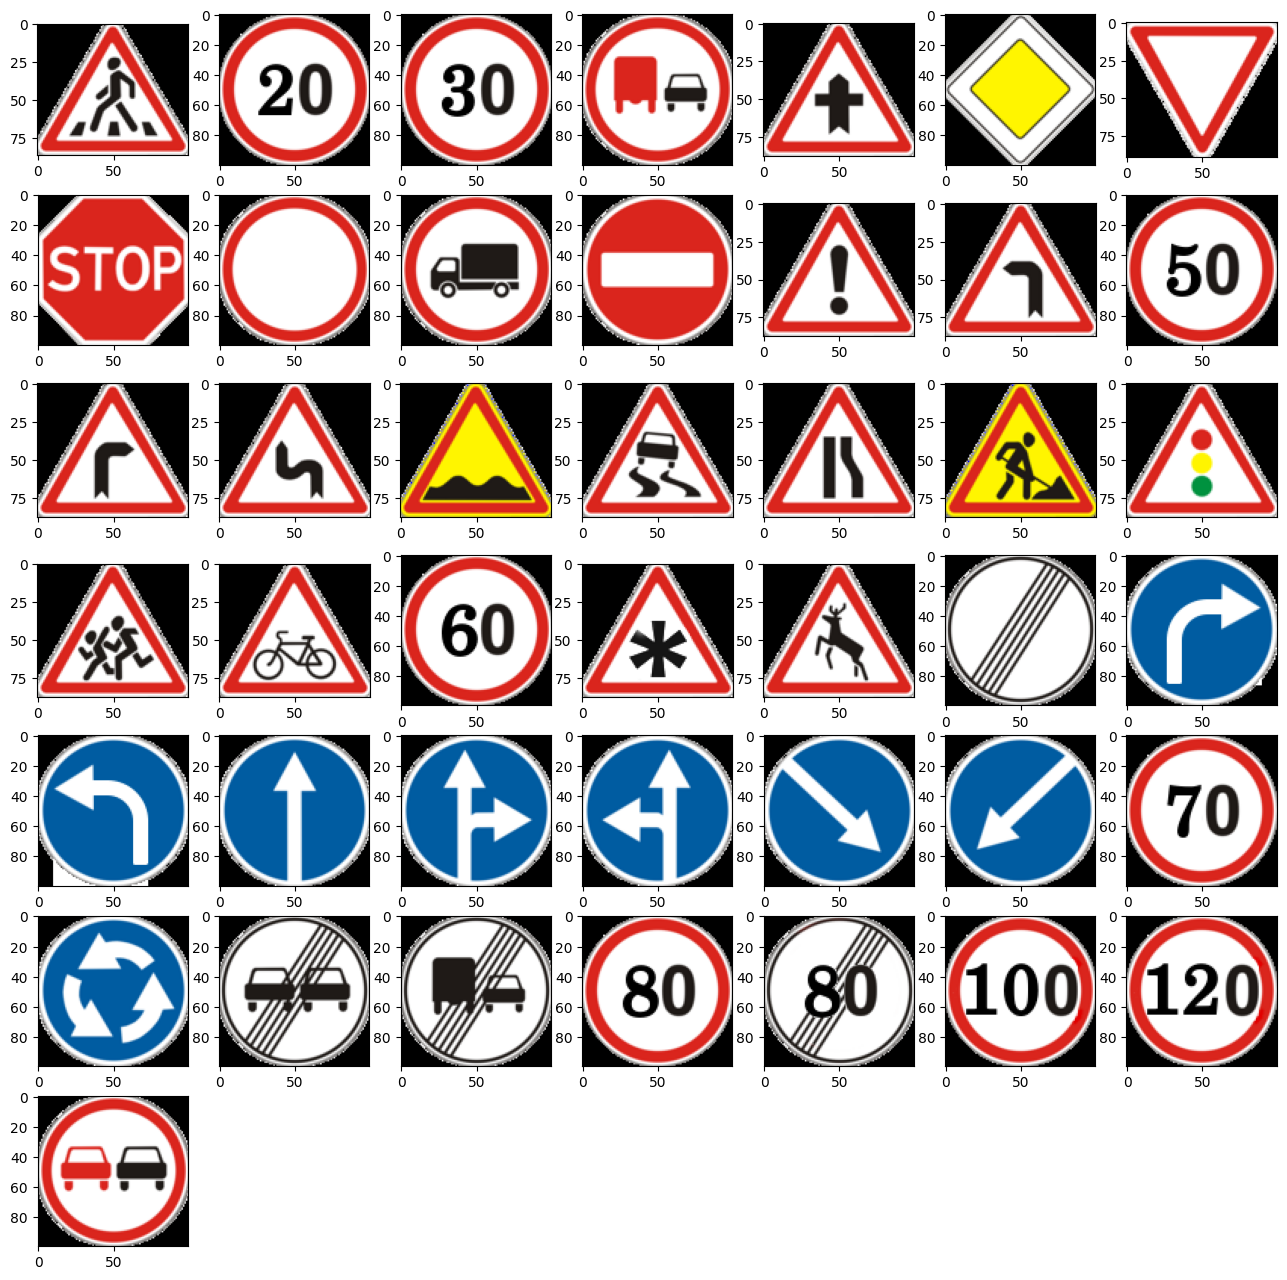

In [6]:
Meta_images = []
Meta_labels = []

plt.figure(figsize=(16,16))
for i in range(len(df_meta)):
    img = load_img('./data/'+df_meta['Path'][i])
    plt.subplot(7, 7, i+1)
    plt.imshow(img)
    Meta_images.append(df_meta['Path'][i])     #파일이름
    Meta_labels.append(df_meta['ClassId'][i])  #ClassId=label로

### 2.2 train csv파일 확인

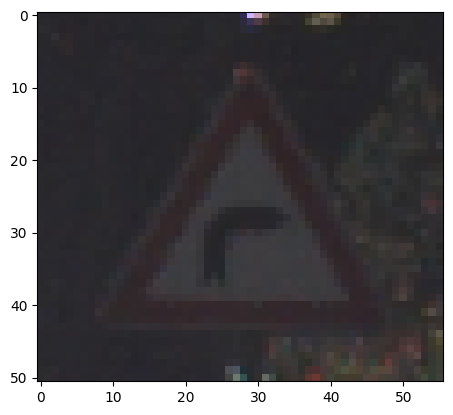

In [7]:
df_train = pd.read_csv('./data/Train.csv')
train_img = load_img('./data/'+df_train['Path'][20])
plt.imshow(train_img)

가로 픽셀수 분포도

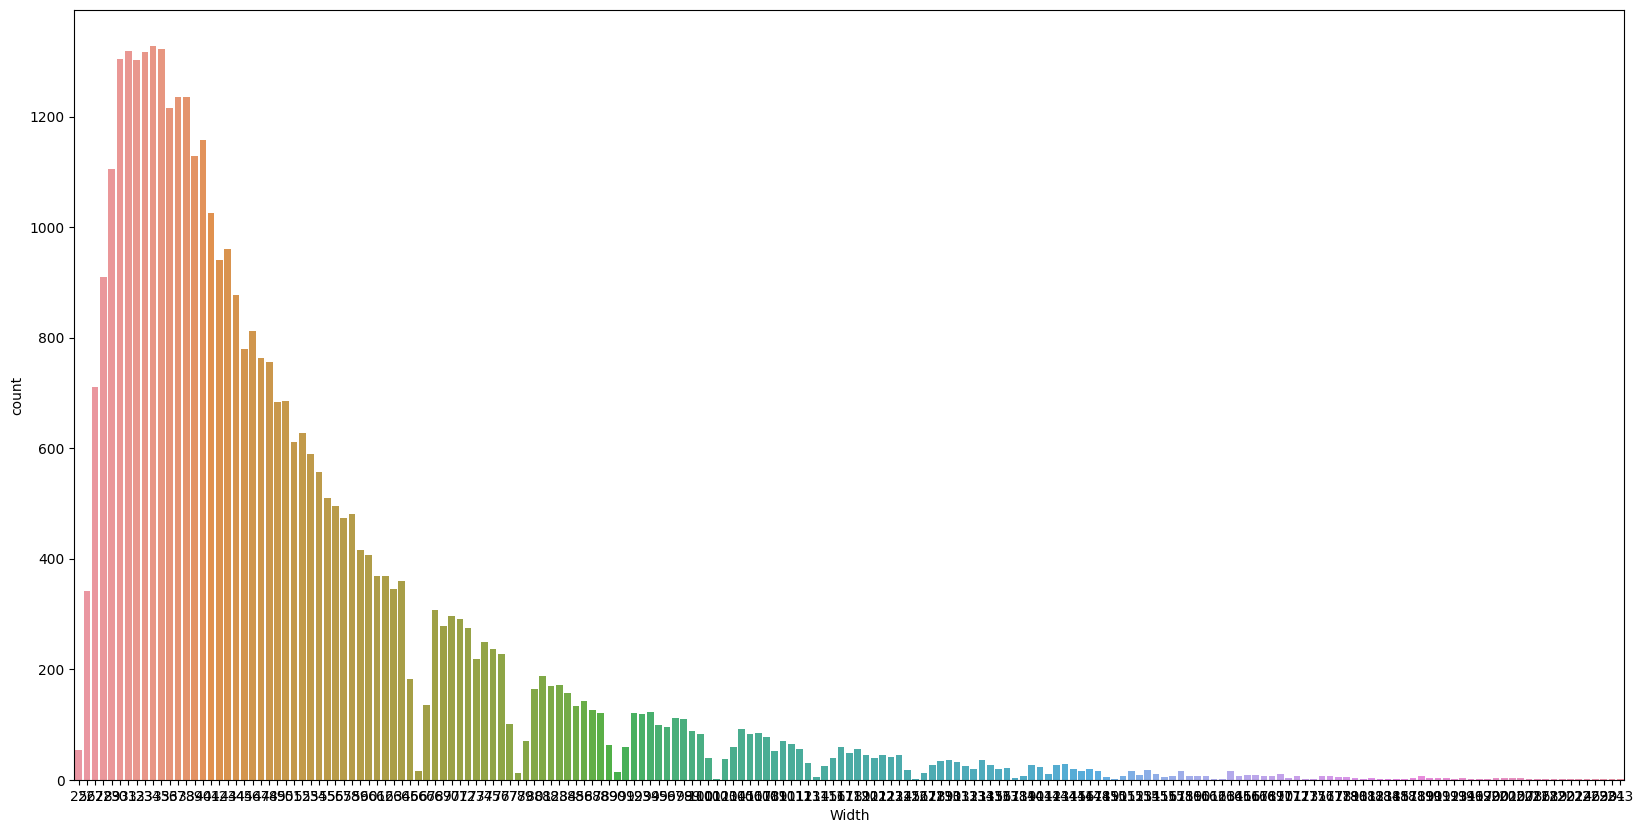

In [8]:
#seaborn 사용
import seaborn as sns
plt.figure(figsize=(20,10))
ax = sns.countplot(x="Width",data=df_train)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29704\606898367.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


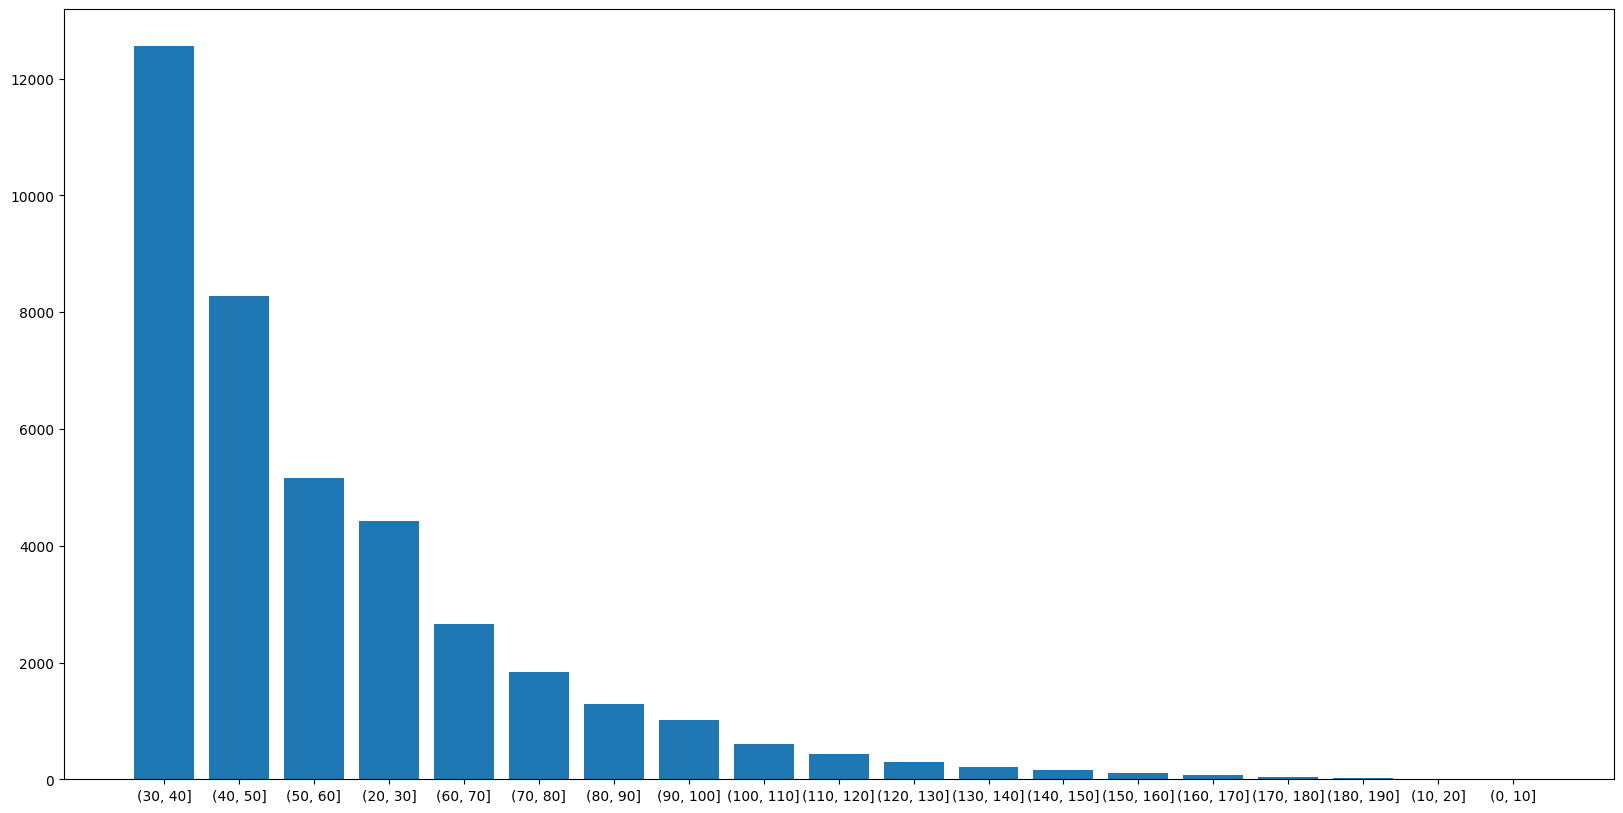

In [9]:
#matbplotlib사용
df_cutWidth = pd.cut(df_train['Width'], np.arange(0,200,10)).value_counts(sort=True) #0~200사이를 10단위로쪼갬, 젤 많은크기로 정렬
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(df_cutWidth)), df_cutWidth.values)
ax.set_xticks(range(len(df_cutWidth)))
ax.set_xticklabels(df_cutWidth.index)
fig.show()

30~40크기를 갖는 분포가 가장 많기때문에
이미지 크기를 33x33으로 동일하게 함.

In [10]:
image_height = 33
image_width = 33
image_channel = 3

Roi 데이터 : 표지판이 있는 부분을 의미
  > 좌측상단 좌표 우측하단 좌표를 의미함

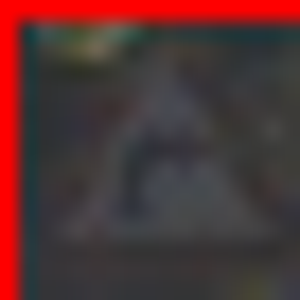

In [11]:
from PIL import Image
from PIL import ImageDraw

img_sample = Image.open('./data/'+df_train['Path'][0])
draw = ImageDraw.Draw(img_sample)

draw.rectangle([df_train['Roi.X1'][0],df_train['Roi.Y1'][0],df_train['Roi.X2'][0],df_train['Roi.Y2'][0]], outline= "red")
#resize
img_sample_resize = img_sample.resize((300,300))
#crop
img_sample_crop = img_sample.crop([df_train['Roi.X1'][0],df_train['Roi.Y1'][0],df_train['Roi.X2'][0],df_train['Roi.Y2'][0]])
img_sample_crop = img_sample_crop.resize((300,300))
img_sample_crop

### 2.3 test csv파일 확인

In [12]:
df_test = pd.read_csv('./data/test.csv')
df_test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


## 3. 데이터 전처리 

###  3.1 이미지 데이터 읽기

통일된 이미지 크기를 불러와 array형태로 저장

In [13]:
image_height = 33
image_width = 33
image_channel = 3

train_images = []
train_labels = []

for i in tqdm(range(len(df_train))):
    img = load_img('./data/'+df_train['Path'][i], target_size = (image_height,image_width))#읽어오면서 파일 size변환
    img = img_to_array(img)
    train_images.append(img)

100%|██████████████████████████████████████████████████████████████████████████| 39209/39209 [00:27<00:00, 1432.23it/s]


In [14]:
test_images = []
test_labels = []

for i in tqdm(range(len(df_test))):
    img = load_img('./data/'+df_test['Path'][i], target_size = (image_height,image_width))
    img = img_to_array(img)
    test_images.append(img)

100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:09<00:00, 1355.36it/s]


train, test 이미지를 array형태로 변환시켜줌

### 3.2 label 데이터 읽기 

In [27]:
print(df_train.columns)  #에서 Classid를 label로 가져옴
train_labels = df_train['ClassId'].values  
test_labels = df_test['ClassId'].values  


Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')


### 3.4 데이터 분리하기 

train, validation으로 분리, np_array형태가 가장 오류가 적음

In [37]:
x_train, x_val, y_train, y_val = train_test_split(np.array(train_images), np.array(train_labels), test_size = 0.3)

In [39]:
x_test = np.array(test_images)
y_test = np.array(test_labels)

## 4. 모델 설계 

In [40]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=(image_height, image_height, image_channel)),#33,33,3형태로 전달
    #33,33,3 - > maxpooling과정을 거치게 되면서 filter_map은 3-1 = 2가 줄어듬
    #따라서 ouputshape - (None, 31,31,32)가 됨.
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(rate=0.25),
    Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

## 5. 모델 학습 

In [41]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy'])


In [42]:
epochs = 30

history = model.fit(x_train,
                   y_train,
                   validation_data=(x_val,y_val),
                   epochs = epochs)

Epoch 1/30
736/736 [==============================] - 14s 18ms/step - loss: 3.0542 - accuracy: 0.4840 - val_loss: 0.6416 - val_accuracy: 0.8290
Epoch 2/30
736/736 [==============================] - 13s 18ms/step - loss: 0.6614 - accuracy: 0.8036 - val_loss: 0.2931 - val_accuracy: 0.9214
Epoch 3/30
736/736 [==============================] - 14s 18ms/step - loss: 0.4398 - accuracy: 0.8674 - val_loss: 0.2050 - val_accuracy: 0.9385
Epoch 4/30
736/736 [==============================] - 14s 19ms/step - loss: 0.3669 - accuracy: 0.8905 - val_loss: 0.1529 - val_accuracy: 0.9561
Epoch 5/30
736/736 [==============================] - 14s 18ms/step - loss: 0.3275 - accuracy: 0.9049 - val_loss: 0.1587 - val_accuracy: 0.9552
Epoch 6/30
736/736 [==============================] - 14s 19ms/step - loss: 0.2999 - accuracy: 0.9131 - val_loss: 0.1270 - val_accuracy: 0.9645
Epoch 7/30
736/736 [==============================] - 14s 19ms/step - loss: 0.3035 - accuracy: 0.9157 - val_loss: 0.1133 - val_accuracy:

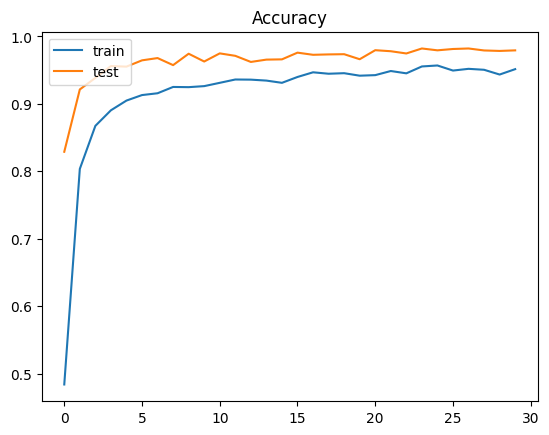

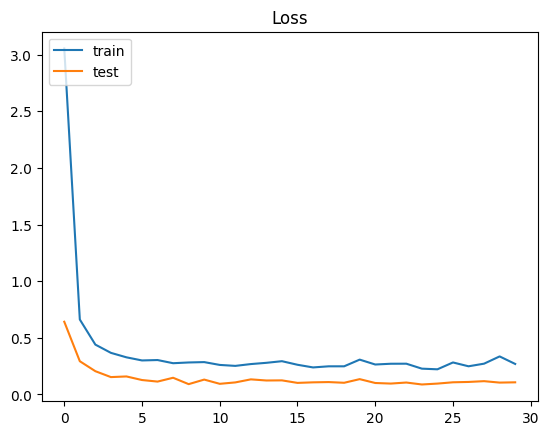

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left') #왼쪽 위에 legend생성
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left') #왼쪽 위에 legend생성
plt.show()

In [44]:
model.save_weights('TrafficSign_recognition_weight.h5py')

In [45]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('test set accuracy: ', test_accuracy)

test set accuracy:  0.9242280125617981


axis=-1은 마지막 축을 지정하므로, 입력 데이터의 형태가 어떠한 차원이더라도 유연하게 최대값을 찾을 수 있다.

In [46]:
test_prediction = np.argmax(model.predict(x_test),axis=-1)

395/395 [==============================] - 1s 3ms/step


In [47]:
predictions = model.predict(x_test)
print(np.argmax(predictions[0], axis=-1))

395/395 [==============================] - 1s 3ms/step
16


In [48]:
test_prediction  #예측된 클래스의 확률 값 배열에서 각 샘플마다 가장 높은 확률을 가지는 클래스의 인덱스를 반환함

array([16,  1, 38, ...,  4,  7, 10], dtype=int64)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.26it/s]


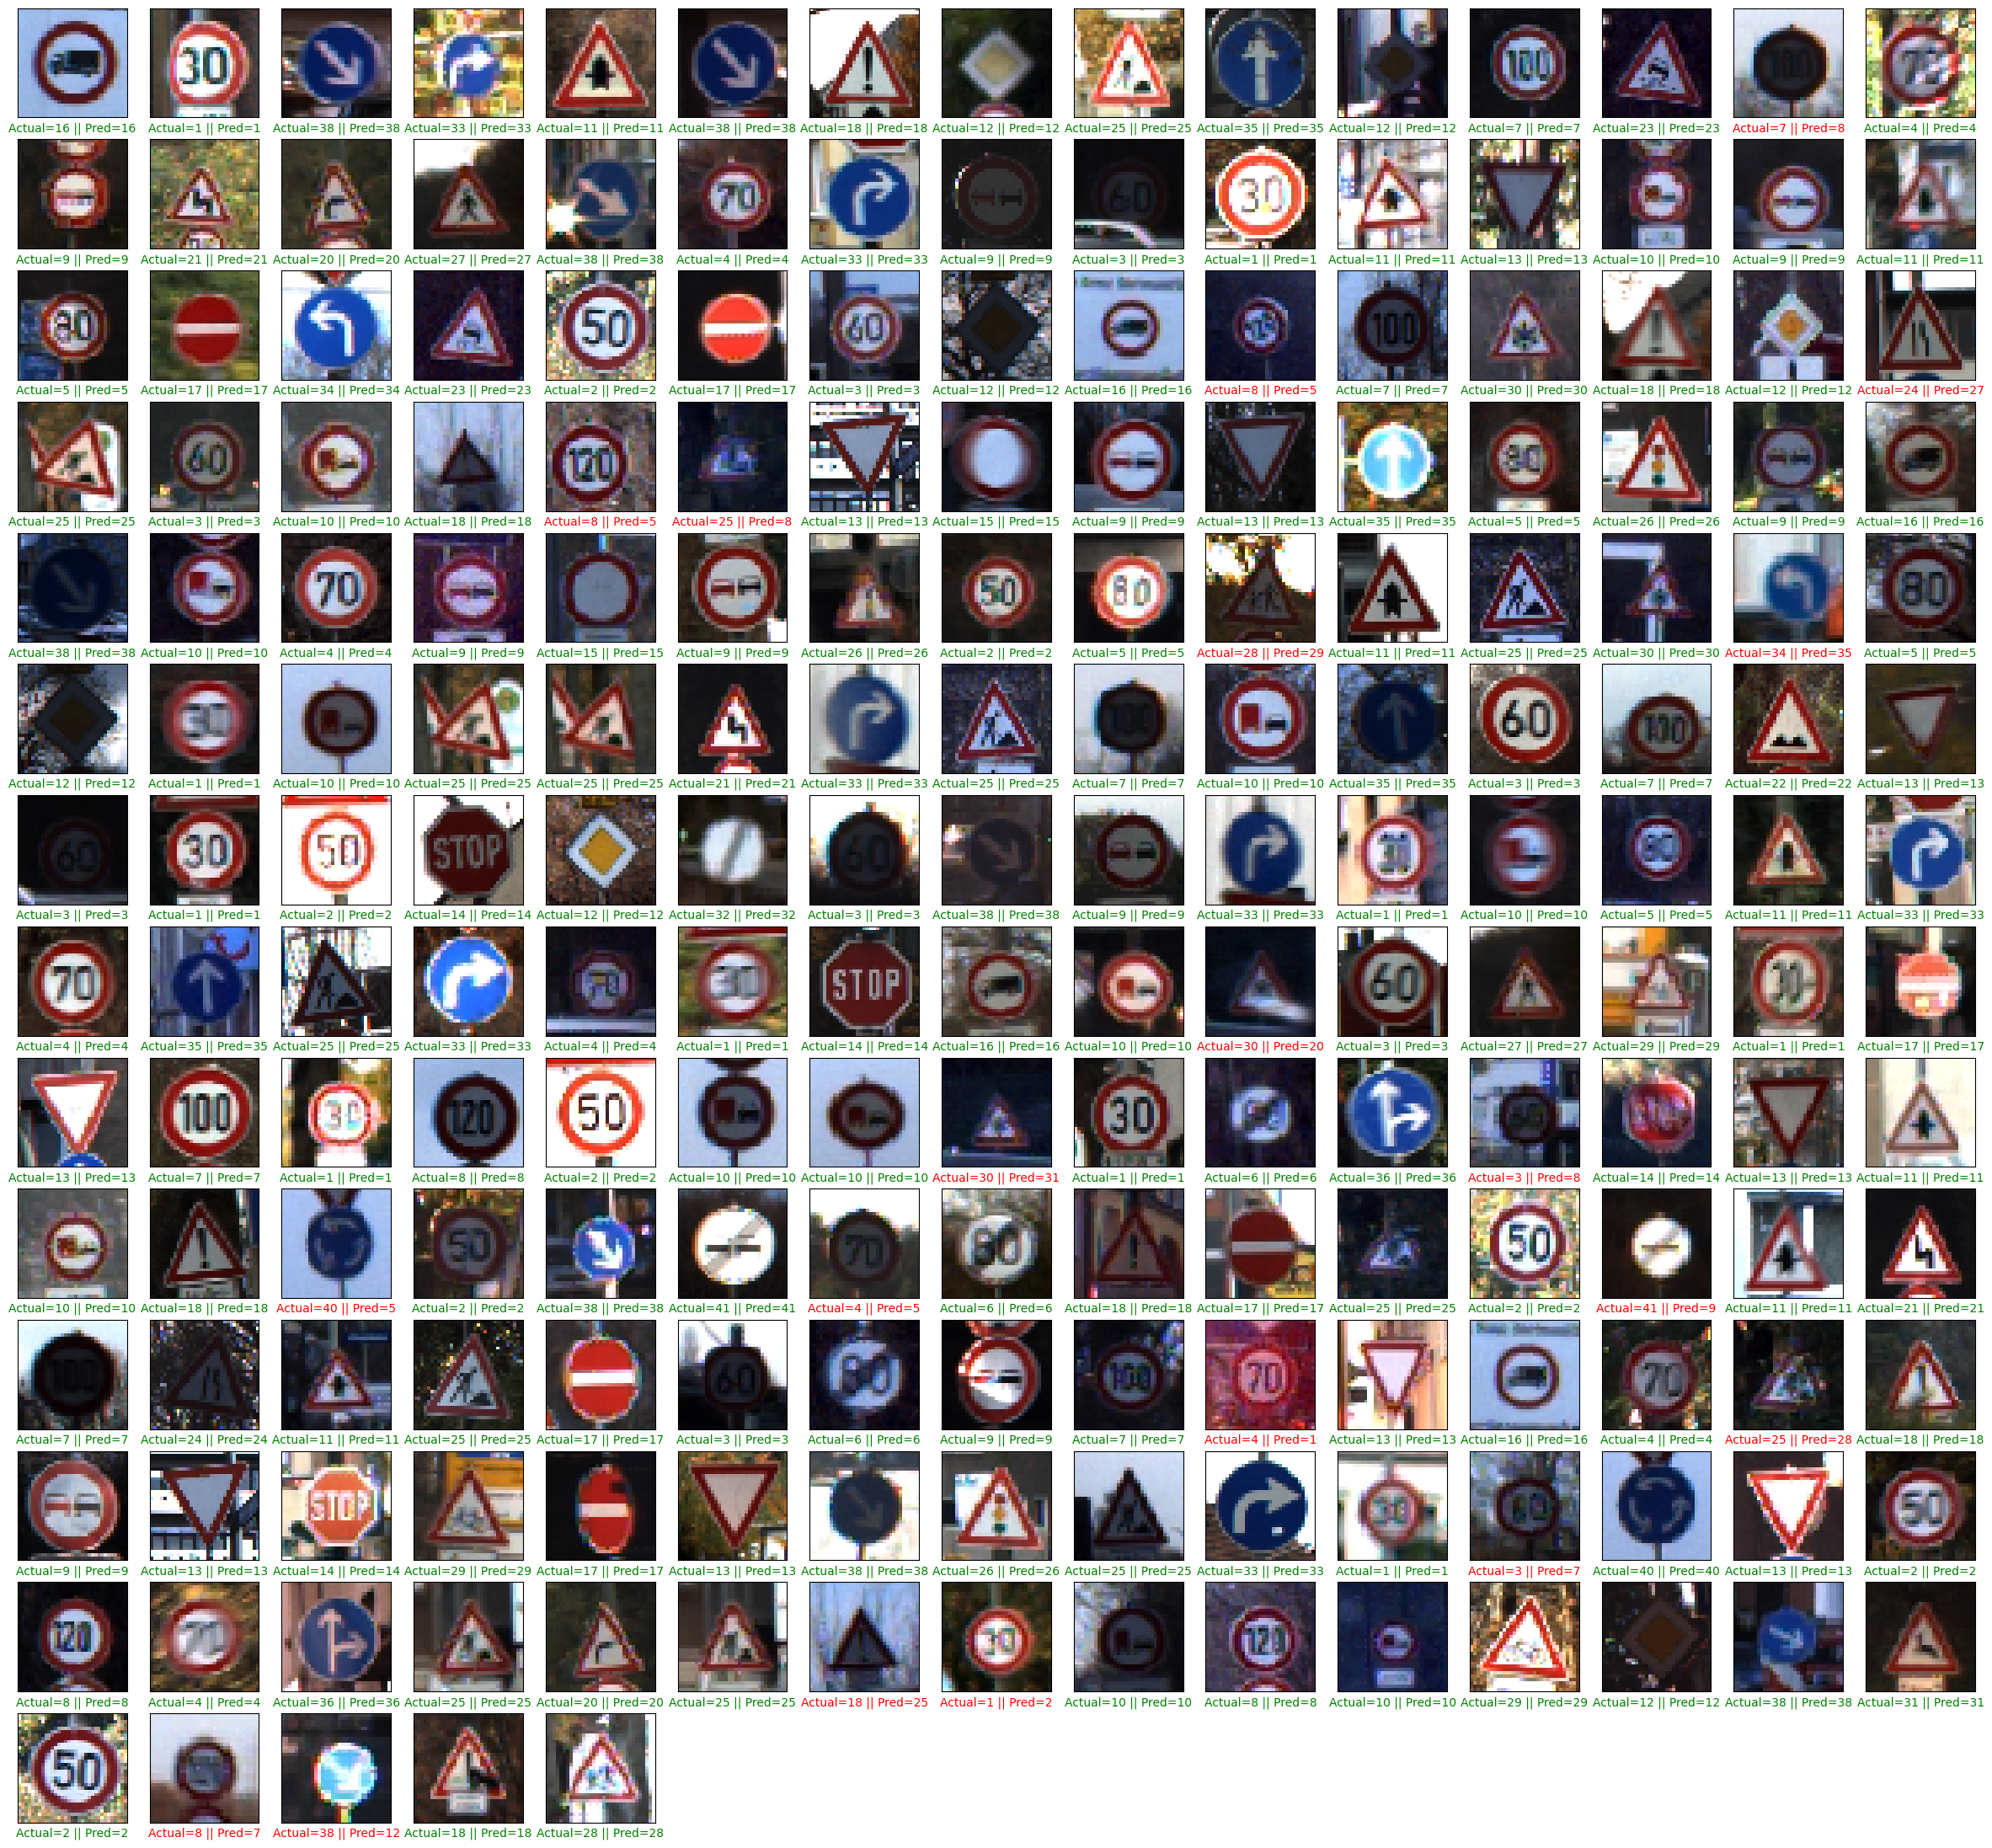

In [59]:
plt.figure(figsize = (30,30))

start_index = 0
for i in tqdm(range(200)):
    plt.subplot(15,15, i + 1)
    plt.xticks([])
    plt.yticks([])
    prediction = test_prediction[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:  #예측과 틀릴때
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(array_to_img(x_test[start_index + i]))
plt.show()